# The contrast-dependence of spatial frequency tuning
## Thesis chapter 1/publication

Here, we'll organize (better than has been organized in the predecesor notebooks __{analysis_ch1, analysis_ch1_suppl, descrAnalysisV1-allExps, V1_clustering, and descrAnalysisLGN]}__ the analysis for chapter 1 of my thesis. The primary intention behind re-doing this notebook (_again_) is that per a meeting in April 2022, Tony and Eero suggested we write this chapter as a paper fit for publication.

In particular, writing this chapter as a paper necessitates re-doing some of the analyses from Sach Sokol's thesis (specifically, his 3rd chapter).

Last access (y.m.d): 22.06.13   
Last update (y.m.d): 22.06.13  

In [1790]:
import helper_fcns as hf
import numpy as np

import warnings
warnings.filterwarnings(action='once')

import os, pdb
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

# what's the save name for this analysis?
saveName = 'figures/reports/ch01_sfTuning_contrast/'; # for one save name for all figures
save_loc = base_dir + saveName;

In [1791]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

# 1.1 LGN

### 1.1.01 - Scaled vs. separate Difference-of-Gaussians (DoG) 

The first key analysis in Sach's thesis is showing that spatial frequency tuning is contrast dependent. Using a $\chi^2$ analysis, he shows that despite using extra parameters, a separate-per-contrast Difference-of-Gaussians (DoG) model outperforms a scaled DoG model. In the scaled model, the shapes and relative magnitudes of the gaussians are fixed, and the resultant curve can only be shifted vertically (i.e. changing response magnitude).

As of 22.04.20, we will not replicate this analysis, taking it as a well-justified in the literature.

### 1.1.02 - Determining which DoG parameters matter most

In section 3.3.4 (_Which DoG parameters can account for contrast-dependent tuning?_), Sach asks which of the DoG parameters are most needed to be adjustable across contrast. Using the more common approaches of the time (thesis defended in 2009), he used a $\chi^2$ analysis which compared the loss of each model while taking into account the number of free parameters. Since computational resources and accessibility have greatly improved in the interim period, we'll instead use cross-validation to compare the different models.

#### The models
- $\Delta$_volume ratio_ (2*$n_{con}$ + 2 free parameters) - center and surround radii are fixed
- $\Delta$_center radius_ (2*$n_{con}$ + 2 free parameters) - surround radius and relative surround gain are fixed
    - Note that the surround radius is fixed in absolute terms
- $\Delta$_surround radius_ (2*$n_{con}$ + 2 free parameters) - center radius and relative surround gain are fixed
- $\Delta$_center-surround_ (3*$n_{con}$ + 1 free parameters) - relative surround gain is fixed

And for thorough comparison, we also include the model with which most prior analysis was done

- $\Delta$_center radius + vol_ (3*$n_{con}$ + 1 free parameters) - relative surround radius is fixed
    - This model differs from $\Delta$_center radius_ in that the surround radius is fixed in relative terms to the center radius at contrast. Further, the relative Gaussian volumes are allowed to changed (since the relative surround gain term is free at each contrast)

#### Cross-validation
In cross-validation, we partition the data into training and test, optimizing the model jointly across all contrasts based only on the training data. We then evaluate the model on the heldout (i.e. test) portion of the data, and assess the loss function. If model X has better training performance than model Y but worse test performance, then we can say that model X is simply overfitting the data. For example, we know that a well-parameterized model with more free parameters will outperform one with fewer parameters; however, how those models perform on heldout data is a better measure of the model's explanatory capabilities.


#### Model performance (all data)
First, we'll compare the model performance when fitting to all of the data.

In [1883]:
# Specify which data to load
phAdj = 1;
# phAdj = 0;

expDirs = ['LGN', 'LGN/sach/'];
joints = [0,2,4,7]
nFreeParams = [4,3,2,2]
names = ['free', 'ctr. r. + vol', 'ctr. r', 'ctr.r. slope, surrRad'];

nlls_all = [];

for expDir in expDirs:

    isSach = 1 if 'sach' in expDir else 0;
    expDir_str = 'sach' if isSach else expDir
    if phAdj:
        date = '220609'
    #     date = '220513a' if isSach else '220512'
    else:
        date = '220609'
    #     date = '220510' if isSach else '220519'


    # joints = [0,2,4,6,7]
    # nFreeParams = [4,3,2,3,2]
    # names = ['free', 'ctr. r. + vol', 'ctr. r', 'ctr-surr', 'ctr.r. slope, surrRad'];

    # joints = [2,7]#,8];
    # nFreeParams = [3,2]#,2]; # how many free params per condition?
    # joints = [2,3,4,5,6];
    # nFreeParams = [3,2,2,2,3]; # how many free params per condition?
    # names = ['ctr. r. + vol', 'ctr.r. slope, surrRad'];
    # names = ['ctr. r. + vol', 'vol. ratio', 'surr. r', 'ctr. r', 'ctr-surr'];
    # if len(joints)>5:
    #     names = ['ctr. r. + vol', 'vol. ratio', 'surr. r', 'ctr. r', 'ctr. r. slope, surrRad', 'ctr-surr'];
    #     names.append('ctr. r. slope, surrGain');    

    isHPC = 1;
    loss_type = 2;
    dog_model = 1;
    if isSach:
        dogName = 'descrFits%s_s%s' % ('HPC' if isHPC else '', date);
    else:
        dogName = 'descrFits%s_%s' % ('HPC' if isHPC else '', date);
    # NOTE: Yes, the naming convention for surr/center radius models are reversed from the fit names
    # --- that's because here (and in Sach's thesis) we model the name by what does shift
    # --- in my naming convention, we name it after what does NOT shift with contrast
    nMods = len(joints);
    ref_ind = 0; # in the index of the joints that we'll use as the reference
    param_color = ['', '', 'r', 'k', 'b']; # what color based on # params per condition

    ref_mod = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=joints[ref_ind], phAdj=phAdj)));
    nCells = len(ref_mod.keys());

    # Now, organize all of the loss values - raw and normalized by the reference models
    raw_ind = 0;
    norm_ind = 1;
    nlls_curr = np.nan * np.zeros((nCells, nMods, 2)); # end is [raw_ind, norm_ind]

    for i,j in enumerate(joints):
        curr_mod = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=j, phAdj=phAdj)));
        if curr_mod == []:
            continue;
        if isSach:
            nlls_curr[:, i, 0] = np.array([curr_mod[x]['totalNLL'] for x in range(nCells)]) if j>0 else np.array([np.nansum(curr_mod[x]['NLL']) for x in range(nCells)]);
        else:
            nlls_curr[:, i, 0] = np.array([curr_mod[x]['totalNLL'][0] for x in range(nCells)]) if j>0 else np.array([np.nansum(curr_mod[x]['NLL'][0]) for x in range(nCells)]);

    # then normalize, too:
    nlls_curr[:,:,1] = np.divide(nlls_curr[:,:,0], np.repeat(np.transpose([nlls_curr[:,ref_ind,0]]), nMods, axis=1))
    
    # and add to overall list...
    if nlls_all == []:
        nlls_all = nlls_curr;
    else:
        nlls_all = np.vstack((nlls_all, nlls_curr));

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Now plot the distributions of losses across all cells (again, this is fitting to all data)

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 62.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


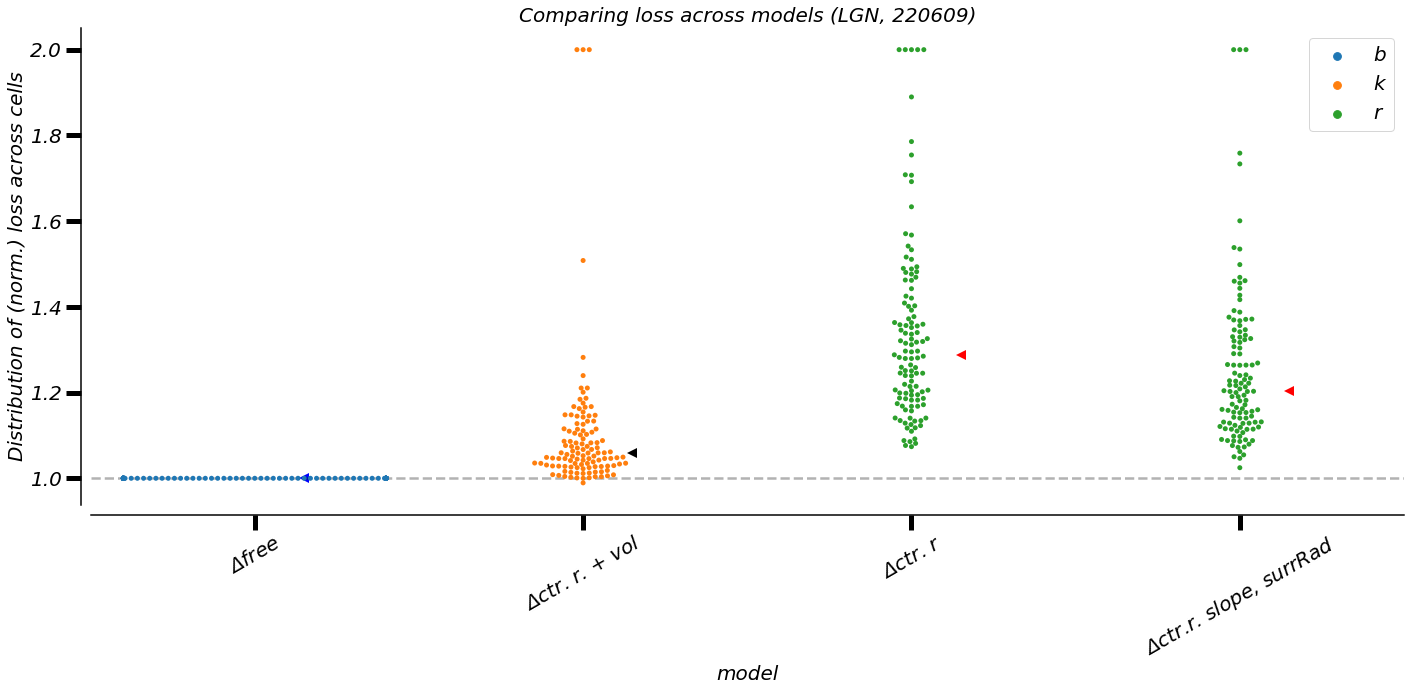

In [1884]:
use_norm = 1;
upper_bound = 2 if use_norm else 1e2;

f = plt.figure(figsize=(5*nMods, 10));

# for ind in range(nMods):
    
#     sns.swarmplot(y=nlls_all[:,ind,use_norm], x=[ind]);
#     viol = plt.violinplot(dataset=nlls_all[:,ind,use_norm], positions=[ind], showextrema=False, widths=0.7);

#     # make all the violin stuff black and transparent
#     for vp in viol['bodies']:
#         vp.set_color(param_color[nFreeParams[ind]])
#         vp.set_alpha(0.2);

nCells = nlls_all.shape[0]
[plt.plot(i+0.15, np.nanmedian(nlls_all[:,i,use_norm]), '<', color=param_color[nFreeParams[i]], markersize=10) for i in range(nMods)]
sns.swarmplot(x=np.tile(np.arange(nMods), nCells), y=hf.flatten_list(np.clip(nlls_all[:,:,use_norm], None, upper_bound)), hue=np.tile([param_color[nFreeParams[x]] for x in range(nMods)], nCells));
sns.despine(offset=10)

if use_norm:
    plt.axhline(1, color='k', linestyle='--', alpha=0.3)

plt.xlabel('model');
plt.ylabel('Distribution of %sloss across cells' % '(norm.) ' if use_norm else '');
plt.xticks(ticks=np.arange(nMods), labels=[r'$\Delta$%s' % x for x in names], rotation=30);
plt.title('Comparing loss across models (LGN, %s)' % date);
plt.tick_params(axis='x', which='minor', bottom=False)
plt.tick_params(axis='y', which='minor', left=False)

f.tight_layout();

saveName = "/01_01_02a_loss_nonCV_%s%s.pdf" % (date, '_norm' if use_norm else '');
curr_dir = os.path.dirname(save_loc+saveName);
if not os.path.exists(curr_dir):
    os.makedirs(curr_dir);
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f); # only one figure here...
pdfSv.close()

In [1805]:
np.where(nlls_all[:,1,1]<1)

(array([34]),)

##### Interlude/optional: Plot loss, by cell, for selected joint models, against separate fits

Per T.M., 22.05.27

In [1801]:
sep_fits = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=0, phAdj=phAdj)));
sep_nlls = np.array([np.nansum(sep_fits[x]['NLL'][0]) for x in range(len(sep_fits.keys()))]);

which_joints = [2,7];
# which_joints = [2,7,3];
which_inds = [np.where(np.array(joints)==x)[0][0] for x in which_joints]


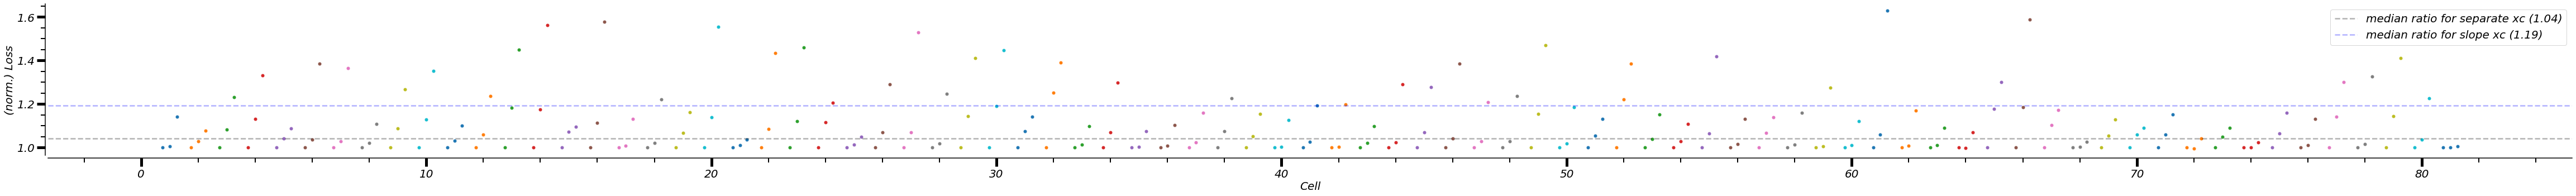

In [1713]:
to_norm = 1; # normalize to sep. fit or no?

# n_rows = np.floor(np.sqrt(nCells)).astype(int);
# n_cols = np.ceil(nCells/n_rows).astype(int);

# f, ax = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows));
plt.figure(figsize=(1*nCells,5))

mdn_rats = [np.nanmedian(np.divide(nlls_all[:,wi,0], sep_nlls)) for wi in which_inds]
mn_rats = [np.nanmean(np.divide(nlls_all[:,wi,0], sep_nlls)) for wi in which_inds]

for cl in range(nCells):
    
    joint_vals = [nlls_all[cl,x,0] for x in which_inds];
    all_vals = (sep_nlls[cl], *joint_vals, )
    
    if to_norm:
        all_vals = all_vals/all_vals[0];
        
    n_mods = len(all_vals)
    steps = cl+1 + 0.25*np.linspace(-1,1,n_mods)
    plt.scatter(steps, all_vals)

plt.axhline(mdn_rats[0], color='k', linestyle='--', label='median ratio for separate xc (%.2f)' % mdn_rats[0], alpha=0.3)
plt.axhline(mdn_rats[1], color='b', linestyle='--', label='median ratio for slope xc (%.2f)' % mdn_rats[1], alpha=0.3)
# plt.axhline(mdn_rats[2], color='r', linestyle='--', label='median ratio for vol. ratio', alpha=0.3)
plt.legend();

plt.ylabel('%sLoss' % ('(norm.) ' if to_norm else ''));
plt.xlabel('Cell');
sns.despine(offset=5)
    
pdfSv = pltSave.PdfPages(save_loc + '220531_phAdv_normNLL_byMod_forTony.pdf');
pdfSv.savefig(plt.gcf()); # only one figure here...
pdfSv.close()


Back to where we were

#### Cross-validation by trial, train fraction = 0.8

As a first attempt, we keep 80% of the data for training and holdout the remaining for testing. We'll first show the training performance and then show loss on test performance.

In [375]:
# # Specify which data to load
# date = '220504'
# isHPC = 1;
# expDir = 'LGN'
# loss_type = 1;
# dog_model = 1;
# has_tr_subset = True;
# dogName = 'descrFits%s_%s' % ('HPC' if isHPC else '', date);

# joints = [3,4,5];
# # joints = [2,3,4,5,6];
# # NOTE: Yes, the naming convention for surr/center radius models are reversed from the fit names
# # --- that's because here (and in Sach's thesis) we model the name by what does shift
# # --- in my naming convention, we name it after what does NOT shift with contrast
# names = ['vol. ratio', 'surr. r', 'ctr. r'];
# # names = ['ctr. r. + vol', 'vol. ratio', 'surr. r', 'ctr. r', 'ctr-surr'];
# nMods = len(joints);
# ref_ind = 0; # in the index of the joints that we'll use as the reference
# nFreeParams = [2,2,2]; # how many free params per condition?
# # nFreeParams = [3,2,2,2,3]; # how many free params per condition?
# param_color = ['', '', 'r', 'k']; # what color based on # params per condition

# ref_mod = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=joints[ref_ind])));
# nCells = len(ref_mod.keys());
# nBoots = ref_mod[0]['boot_paramList'].shape[0];

# # Now, organize all of the loss values - raw and normalized by the reference models
# raw_ind = 0;
# norm_ind = 1;
# nlls_train_all = np.nan * np.zeros((nCells, nBoots, nMods, 2)); # end is [raw_ind, norm_ind]
# nlls_train_subset_all = np.nan * np.zeros((nCells, nBoots, nMods, 2)); # end is [raw_ind, norm_ind]
# nlls_test_all = np.copy(nlls_train_all)

# for i,j in enumerate(joints):
#     curr_mod = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=j)));
# #     nlls_train_all[:, :, i, 0] = [np.nansum(curr_mod[x]['boot_NLL_cv_train'][0][:,0,:], axis=1) for x in range(nCells)];
# #     nlls_test_all[:, :, i, 0] = [np.nansum(curr_mod[x]['boot_NLL_cv_test'][0][:,0,:], axis=1) for x in range(nCells)];
# #     if has_tr_subset:
# #         nlls_train_subset_all[:, :, i, 0] = [np.nansum(curr_mod[x]['boot_NLL_cv_train_subset'][0][:,0,:], axis=1) for x in range(nCells)];
#     for c in range(nCells):
#         if 'boot_NLL_cv_train' in curr_mod[c]:
#             nlls_train_all[c, :, i, 0] = np.nansum(curr_mod[c]['boot_NLL_cv_train'][0][:,0,:], axis=1);
#         if 'boot_NLL_cv_test' in curr_mod[c]:
#             nlls_test_all[c, :, i, 0] = np.nansum(curr_mod[c]['boot_NLL_cv_test'][0][:,0,:], axis=1)
#         if has_tr_subset and 'boot_NLL_cv_train_subset' in curr_mod[c]:
#             nlls_train_subset_all[c, :, i, 0] = np.nansum(curr_mod[c]['boot_NLL_cv_train_subset'][0][:,0,:], axis=1)


# # then, normalize, too:
# nlls_train_all[:,:,:,1] = np.divide(nlls_train_all[:,:,:,0], np.expand_dims(np.nanmin(nlls_train_all[:,:,ref_ind,0], axis=1), axis=(1,2)))
# nlls_test_all[:,:,:,1] = np.divide(nlls_test_all[:,:,:,0], np.expand_dims(np.nanmin(nlls_test_all[:,:,ref_ind,0], axis=1), axis=(1,2)))
# if has_tr_subset:
#     nlls_train_subset_all[:,:,:,1] = np.divide(nlls_train_subset_all[:,:,:,0], np.expand_dims(np.nanmin(nlls_train_subset_all[:,:,ref_ind,0], axis=1), axis=(1,2)))


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: All-NaN slice encountered


In [376]:
# lbl = ['train', 'subset(tr)', 'test']
# all_data = [nlls_train_all, nlls_train_subset_all, nlls_test_all]
# # lbl = ['train', 'test']
# # all_data = [nlls_train_all, nlls_test_all]

# nComps = len(lbl);

# for cell_num in range(nCells):

#     sharey = True if nComps>2 else False;
#     f, ax = plt.subplots(1, nComps, figsize=(nComps*10,10), sharey=sharey);

# #     # train
# #     sns.swarmplot(x=np.tile(np.arange(nMods), nBoots), y=hf.flatten_list(nlls_train_all[cell_num,:,:,0]), hue=np.tile([param_color[nFreeParams[x]] for x in range(nMods)], nBoots), alpha=0.5, ax=ax[0]);
# #     [ax[0].plot(i+0.25, np.nanmean(nlls_train_all[cell_num,:,i,0]), '<', color=param_color[nFreeParams[i]], markersize=10) for i in range(nMods)];

# #     # test
# #     sns.swarmplot(x=np.tile(np.arange(nMods), nBoots), y=hf.flatten_list(nlls_test_all[cell_num,:,:,0]), hue=np.tile([param_color[nFreeParams[x]] for x in range(nMods)], nBoots), alpha=0.5, ax=ax[1]);
# #     [ax[1].plot(i+0.25, np.nanmean(nlls_test_all[cell_num,:,i,0]), '<', color=param_color[nFreeParams[i]], markersize=10) for i in range(nMods)];

#     for j,dta in enumerate(all_data):
#         sns.swarmplot(x=np.tile(np.arange(nMods), nBoots), y=hf.flatten_list(dta[cell_num,:,:,0]), hue=np.tile([param_color[nFreeParams[x]] for x in range(nMods)], nBoots), alpha=0.5, ax=ax[j]);
#         [ax[j].plot(i+0.25, np.nanmean(dta[cell_num,:,i,0]), '<', color=param_color[nFreeParams[i]], markersize=10) for i in range(nMods)];

#     sns.despine(offset=10)
#     f.suptitle('Comparing models with cross-validation')

#     for i in range(nComps):
#         ax[i].set_xlabel('Model');
#         ax[i].set_ylabel('Loss per joint fit')
#         ax[i].set_title('%s' % lbl[i]);
#         ax[i].set_xticklabels(labels=[r'$\Delta$%s' % x for x in names], rotation=30);

#     saveName = "/01_01_02b_comps_%s/cell_%03d.pdf" % (date, cell_num+1);
#     curr_dir = os.path.dirname(save_loc+saveName);
#     if not os.path.exists(curr_dir):
#         os.makedirs(curr_dir);
#     pdfSv = pltSave.PdfPages(save_loc + saveName);
#     pdfSv.savefig(f); # only one figure here...
#     pdfSv.close()
#     f.clf();

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_laun

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_laun

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

#### Cross-validation by condition

Rather than withholding a certain fraction of trials in each condition, we can also cross-validate by leaving out one condition per fit, and evaluating the loss on that heldout condition.

In [1789]:
expDirs

['LGN', 'LGN/sach/']

In [1877]:
# Specify which data to load
# -- for LGN, use 220505
# -- for Sach, use 220510

# thresh = 10;
thresh = -1e5;

phAdj = 1;
# phAdj = 0;

nlls_summary_all = [];

for expDir in expDirs:

    # Load the datalist, so that we can check the responses, and only consider responses > 5 spks/sec?
    if 'ach' not in expDir:
        dl_name = hf.get_datalist(expDir+'/')
    else:
        dl_name = 'sachData.npy'
    dl = hf.np_smart_load('%s/structures/%s' % (expDir, dl_name));
    if 'ach' not in expDir:
        cell_names = dl['unitName'];

    isSach = 1 if 'sach' in expDir else 0;
    expDir_str = 'sach' if isSach else expDir
    if phAdj:
        date = '220607'
#         date = '220513a' if isSach else '220512'
    else:
        date = '220510' if isSach else '220519'
    #     date = '220510' if isSach else '220505'
    isHPC = 1;
    loss_type = 2;
    dog_model = 1;
    if isSach:
        dogName = 'descrFits%s_s%s' % ('HPC' if isHPC else '', date);
    else:
        dogName = 'descrFits%s_%s' % ('HPC' if isHPC else '', date);

    nMods = len(joints);
    ref_ind = 1; # in the index of the joints that we'll use as the reference

    ref_mod = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=joints[ref_ind], phAdj=phAdj)));
    nCells = len(ref_mod.keys());
    if isSach:
        nBoots = ref_mod[0]['boot_paramList'].shape[0];
    else:
        nBoots = ref_mod[0]['boot_paramList'].shape[0];

    print('%s --> %02d cells' % (expDir, nCells))
    
    # Now, organize all of the loss values - raw and normalized by the reference models
    train_ind=0;
    test_ind=1;
    ### As for organizing/analyzing, let's do the following:
    # 1. Here, each model gets one number - total loss across all conditions
    # --- then ...,2 for non-heldout total LOSS [0] and [1] for the sum of all single-condition-holdout test losses
    nlls_summary = np.nan * np.zeros((nCells, nMods, 2));
    # 2. Now, split the loss into condition - i.e. one test loss per sfXcon condition
    # --- and again ...,2 for loss when condition incl. in fit [0] and [1] heldout (i.e. test)
    # - Well, first we need to find out how many CONS/SFS for each cell
    # --- we can work backwords, since nBoots for c-v by cond. is nB=nCons*nSfs and the length of NLL is #cons
    if isSach:
        nCons_perCell = np.array([ref_mod[c]['NLL'].shape[-1] for c in ref_mod.keys()]);
        nBoots_perCell = np.array([ref_mod[c]['boot_NLL_cv_test'].shape[0] for c in ref_mod.keys()]);
    else:
        nCons_perCell = np.array([np.sum(~np.isnan(ref_mod[c]['NLL'][0])) for c in ref_mod.keys()]);
        nBoots_perCell = np.array([ref_mod[c]['boot_NLL_cv_test'][0].shape[0] for c in ref_mod.keys()]);
    nSfs_perCell = np.divide(nBoots_perCell, nCons_perCell).astype('int');
    nCons, nSfs = np.max(nCons_perCell), np.max(nSfs_perCell);
    # NOTE: As of 22.05.11, we can only evaluate loss per contrast for the full model (i.e. train)
    nlls_summary_perCon = np.nan * np.zeros((nCells, nMods, nCons, 2));
    nlls_summary_perSf = np.nan * np.zeros((nCells, nMods, nSfs, 2));
    # nlls_summary_perCond = np.nan * np.zeros((nCells, nMods, nCons, nSfs, 2));
    sfs_perCell = [];
    ref_charFreq_perCell = [];

    for i,j in enumerate(joints):
        curr_mod = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=j, phAdj=phAdj)));
        for c in range(nCells):

            # let's find out the high contrast char. freq as inferred from the ref mod
            if not isSach:
                ref_charFreq_perCell.append(hf.dog_charFreq(ref_mod[c]['params'][0,-1], DoGmodel=dog_model));
            else: # high contrast
                ref_charFreq_perCell.append(hf.dog_charFreq(ref_mod[c]['params'][-1], DoGmodel=dog_model));

            test_nll = np.copy(curr_mod[c]['boot_NLL_cv_test']) if isSach else curr_mod[c]['boot_NLL_cv_test'][0];
            
            if thresh>0:
                cell_name = cell_names[c] if not isSach else dl[c]['cellName']

                # let's also load the current cell and get the SFS so we can:
                # - evaluate the REFERENCE model (only) on these SFS
                # --- why ref. model? so that we make sure that we consider the same conditions for all models
                # - and optionally filter out any conditions with a response below a particular value
                # NOTE: boot_NLL_cv conditions are ordered by sf
                # -- i.e. conditions 0-X are the lowest contrast, first X SFs; then X+1-2x are second lowest contrast...and so on
                curr_cell = hf.np_smart_load('%s/structures/%s_sfm.npy' % (expDir, cell_names[c]));
                expInd = hf.get_exp_ind('%s/structures/' % expDir, cell_names[c])[0];
                _,conds,vc,_,_=hf.tabulate_responses(curr_cell['sfm']['exp']['trial'], expInd=expInd)
                sfs = conds[2]
                sfs_perCell.append(sfs);
                mod_resps = np.array([hf.get_descrResp(ref_mod[c]['params'][0,x], sfs, DoGmodel=dog_model) for x in np.where(~np.isnan(ref_mod[c]['params'][0,:,-1]))[0]]);
                # ^ mod_resps is nCons x nSfs (i.e. exactly as boot_NLL_cv once flattened)
                mod_rps = mod_resps.flatten();
                inval_conds = np.where(mod_rps<thresh)[0];

                if isSach:
                    test_nll[inval_conds] = 0; # just zero it
                else:
                    test_nll[inval_conds,0] = 0; # just zero it           

            # First, handle the totalNLL
            # -- train
            try:
                if j>0:
                    nlls_summary[c,i,train_ind] = curr_mod[c]['totalNLL'] if isSach else curr_mod[c]['totalNLL'][0] 
                else:
                    nlls_summary[c,i,train_ind] = np.nansum(curr_mod[c]['NLL']) if isSach else np.nansum(curr_mod[c]['NLL'][0])
            except:
                pass;
            # -- test
            try:
                nlls_summary[c,i,test_ind] = np.nansum(test_nll) if isSach else np.nansum(test_nll[:,0]); # if not Sach, we have to specify that it's zero dispersion
            except:
                pass;
            # Now, we'll split per contrast
            # -- train
            try:
                curr_perCond = hf.nan_rm(curr_mod[c]['NLL']) if isSach else hf.nan_rm(curr_mod[c]['NLL'][0]);
                nlls_summary_perCon[c,i,0:len(curr_perCond),train_ind] = curr_perCond;
            except:
                pass;
            # -- test
            try:
                # by contrast
                curr_perCond = np.nansum(test_nll, axis=0) if isSach else np.nansum(test_nll[:,0],axis=0)
                curr_perCond = curr_perCond[curr_perCond>0]; # if it's 0, then this is just a missing condition
                nlls_summary_perCon[c,i,0:len(curr_perCond),test_ind] = curr_perCond;
                # and now, by SF, too
                nConds = curr_mod[c]['boot_NLL_cv_test'].shape[0] if isSach else curr_mod[c]['boot_NLL_cv_test'][0].shape[0];
                nSfs_curr=nSfs_perCell[c];x
                if isSach:
                    curr_perCond = np.array([np.nansum([test_nll[tot_ind,con_ind] for con_ind,tot_ind in enumerate(np.arange(x, nConds, nSfs_curr))]) for x in range(nSfs_curr)]);
                else:
                    val_cons = vc[0]; # 0 disp case
                    # why? for my data, we need to access only the relevant contrast indices
                    curr_perCond = np.array([np.nansum([test_nll[tot_ind,0,val_cons[con_ind]] for con_ind,tot_ind in enumerate(np.arange(x, nConds, nSfs_curr))]) for x in range(nSfs_curr)]);
                curr_perCond = curr_perCond[curr_perCond>0]; # if it's 0, then this is just a missing condition
                nlls_summary_perSf[c,i,0:len(curr_perCond),test_ind] = curr_perCond;
            except:
                pass;
            
    # then, combine!
    if nlls_summary_all == []:
        nlls_summary_all = nlls_summary;
    else:
        nlls_summary_all = np.vstack((nlls_summary_all, nlls_summary));


LGN --> 81 cells
LGN/sach/ --> 34 cells


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:156: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


##### Now, let's get some summaries/plots
First, across cells

In [1867]:
# Here's how we can find out which model had the lowest loss across cells
lowest = np.argmin(nlls_summary_all[:,:,test_ind],axis=1)
_, freqs = np.unique(lowest, return_counts=True)
nCells = nlls_summary_all.shape[0]

In [1868]:
[print('(%.1f%%) %02d out of %02d cells: %s had the lowest test loss' % (100*f/nCells, f,nCells,n)) for n,f in zip(names,freqs)]

(70.4%) 81 out of 115 cells: free had the lowest test loss
(0.9%) 01 out of 115 cells: ctr. r. + vol had the lowest test loss
(17.4%) 20 out of 115 cells: ctr. r had the lowest test loss
(11.3%) 13 out of 115 cells: ctr.r. slope, surrRad had the lowest test loss


[None, None, None, None]

In [1235]:
# And just for debugging purposes, let's list out the cells for which each model was best
for ind in np.unique(lowest):
    bests = np.where(lowest==ind)[0];
    if len(bests)>0:
        print('%s model was best for cells: %s' % (names[ind], np.array2string(bests+1))) # add 1 to go from index to cell#
    else:
        print('%s model was never the best!')

ctr. r. + vol model was best for cells: [19 20 30 35 44 55 56 59 64]
ctr. r model was best for cells: [ 2  4  7  8  9 13 14 17 18 21 24 27 31 32 36 49 51 58 60 61 67 69 73 75
 76]
ctr. r. slope, surrRad model was best for cells: [ 1  3  5 11 12 15 22 23 25 26 33 37 38 40 46 47 48 50 52 53 54 62 63 65
 68 70 71 72 74 77 78 79 80 81]
ctr-surr model was best for cells: [ 6 10 16 28 29 34 39 41 42 43 45 57 66]


Now, let's look _within_ each cell, across contrasts

In [ ]:
lbl = ['train', 'test']

for c in range(nCells):

    f, ax = plt.subplots(1,2,figsize=(20,8), sharey=True)

    for i in range(2):

        [ax[i].plot(x[:,i], label='%s [%.2f]' % (md, np.nansum(x[:,i]))) for x,md in zip(nlls_summary_perCon[c], names)]
        ax[i].legend(fontsize='x-small');
        ax[i].set_xlabel('increasing contrast');
        if i==0:
            ax[i].set_ylabel('loss across all sfs');
        ax[i].set_title('%s loss' % lbl[i])
    f.suptitle('Cell %02d - comparing train/test loss across con.' % (c+1))
    sns.despine(offset=5)
    
    # Now save, too
    saveName = "/01_01_02c_comps%s_%s%s/cell_%03d.pdf" % (expDir_str, date, phAdj_str, c+1);
    curr_dir = os.path.dirname(save_loc+saveName);
    if not os.path.exists(curr_dir):
        os.makedirs(curr_dir);
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f); # only one figure here...
    pdfSv.close();
    f.clf();

...and also across SFs (as of 22.05.18, will ignore the training data, since that's harder to get)

In [1224]:
lbl = ['train', 'test']

for c in range(nCells):

    f, ax = plt.subplots(1,2,figsize=(20,8), sharey=True)

    for i in range(2):

        # messy code, but we're subsetting the loss per Sf to match the length of the actual SFS that appear for this cell (we build the array to handle the largets possible # of sfs)
        [ax[i].semilogx(sfs_perCell[c], x[np.arange(len(sfs_perCell[c])), i], label='%s [%.2f]' % (md, np.nansum(x[:,i]))) for x,md in zip(nlls_summary_perSf[c], names)]
#         [ax[i].plot(x[:,i], label='%s [%.2f]' % (md, np.nansum(x[:,i]))) for x,md in zip(nlls_summary_perSf[c], names)]
        ax[i].legend(fontsize='x-small');
        if i == 1:
            ax[i].axvline(ref_charFreq_perCell[c], linestyle='--', alpha=0.3)
        if i==0:
            ax[i].set_ylabel('loss across all contrasts');
        ax[i].set_title('%s loss' % lbl[i])
    f.suptitle('Cell %02d - comparing train/test loss across SF (index)' % (c+1))
    sns.despine(offset=5)
    
    # Now save, too
    saveName = "/01_01_02c_comps%s_%s%s/bySf_cell_%03d.pdf" % (expDir_str, date, phAdj_str, c+1);
    curr_dir = os.path.dirname(save_loc+saveName);
    if not os.path.exists(curr_dir):
        os.makedirs(curr_dir);
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f); # only one figure here...
    pdfSv.close();
    f.clf();

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

#### Interlude: Comparing volRatio (e.g. only center gain shifts) vs model in which center gain and radius can shift

In [1291]:
dogName

'descrFitsHPC_220519'

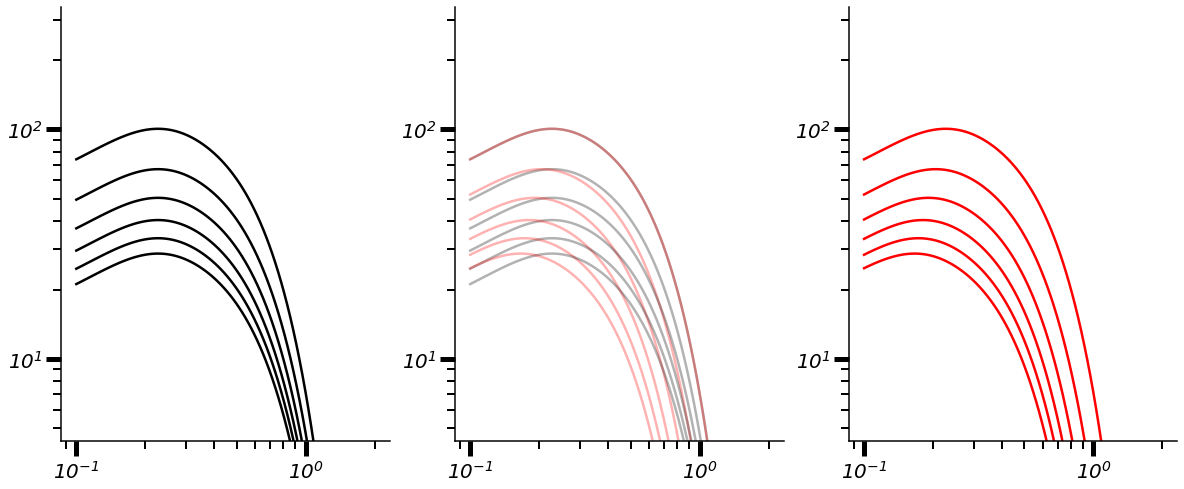

In [1300]:
lt = 2; # loss type
dn = 'descrFitsHPC_220519'
dm = 1; # dog model
jnt = 3; # which joint type to load?
vr = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(lt, descrBase=dn, modelName=hf.descrMod_name(dm), joint=jnt, phAdj=-1)));

prms_ref = vr[74]['params'][0,-1];
sfs = np.geomspace(0.1,2,100);

steps = np.arange(1,4,0.5)

f, ax = plt.subplots(1, 3, figsize=(20,8))#, sharex=True, sharey=True);

for i in steps:

    # first, change only the center gain (i.e. delta volume...)
    prms_curr = np.copy(prms_a);
    prms_curr[0] = prms_curr[0]/i

    ax[0].loglog(sfs, hf.get_descrResp(prms_curr, sfs, 1), color='k');
    ax[1].loglog(sfs, hf.get_descrResp(prms_curr, sfs, 1), color='k', alpha=0.3);
    ax[0].axis('equal');
    ax[0].set_ylim([5e0, 3e2])
    
    # then, also change the center radius
    prms_curr[1] = prms_curr[1]*np.power(i, 0.25); # 4th power just to make the differences less stark...
    ax[2].loglog(sfs, hf.get_descrResp(prms_curr, sfs, 1), color='r');
    ax[1].loglog(sfs, hf.get_descrResp(prms_curr, sfs, 1), color='r', alpha=0.3);
    ax[2].axis('equal');
    ax[2].set_ylim([5e0, 3e2])

   
    ax[1].axis('equal');
    ax[1].set_ylim([5e0, 3e2])


In [840]:
nlls_summary_perSf.shape

(81, 7, 11, 2)

In [857]:
nlls_summary_perSf.shape

(81, 7, 11, 2)

In [861]:
nlls_summary_perSf[45,:,-3,1]

array([1.82562542, 1.63666403, 1.81104732, 1.47182488, 2.71209955,
       1.4137392 , 2.76793146])

In [860]:
nlls_summary_perSf[4,:,-3,1]

array([2.43792725, 0.95836103, 1.11097932, 1.71929193, 3.7235508 ,
       1.23199368, 3.7647047 ])

In [849]:
nlls_summary_perSf[4,:,:,1]

array([[3.80026579, 0.83619457, 0.33138499, 0.40872857, 0.49870372,
        1.14088392, 1.3713783 , 1.17187798, 2.43792725,        nan,
               nan],
       [3.81955695, 0.76390767, 0.27976018, 0.25278738, 0.44662476,
        1.06000316, 1.22319162, 0.94020379, 0.95836103,        nan,
               nan],
       [2.21463656, 0.3606168 , 0.34687713, 0.31712756, 0.46362698,
        0.94576359, 2.19754457, 0.85412997, 1.11097932,        nan,
               nan],
       [2.94116378, 0.60775548, 0.39087319, 0.23985654, 0.7863068 ,
        1.14692581, 1.48091555, 1.17275465, 1.71929193,        nan,
               nan],
       [3.08905745, 0.47167683, 0.36670679, 0.27754152, 0.62585962,
        0.92494762, 2.05699539, 1.19365752, 3.7235508 ,        nan,
               nan],
       [3.43502831, 0.65983844, 0.55951512, 0.22841446, 1.84784794,
        1.60114193, 1.13316524, 1.13475049, 1.23199368,        nan,
               nan],
       [2.89677548, 0.35696429, 1.02322757, 0.81354058, 1.

In [864]:
nlls_summary_perSf[4,:,:,1]

array([[3.80026579, 0.83619457, 0.33138499, 0.40872857, 0.49870372,
        1.14088392, 1.3713783 , 1.17187798, 2.43792725,        nan,
               nan],
       [3.81955695, 0.76390767, 0.27976018, 0.25278738, 0.44662476,
        1.06000316, 1.22319162, 0.94020379, 0.95836103,        nan,
               nan],
       [2.21463656, 0.3606168 , 0.34687713, 0.31712756, 0.46362698,
        0.94576359, 2.19754457, 0.85412997, 1.11097932,        nan,
               nan],
       [2.94116378, 0.60775548, 0.39087319, 0.23985654, 0.7863068 ,
        1.14692581, 1.48091555, 1.17275465, 1.71929193,        nan,
               nan],
       [3.08905745, 0.47167683, 0.36670679, 0.27754152, 0.62585962,
        0.92494762, 2.05699539, 1.19365752, 3.7235508 ,        nan,
               nan],
       [3.43502831, 0.65983844, 0.55951512, 0.22841446, 1.84784794,
        1.60114193, 1.13316524, 1.13475049, 1.23199368,        nan,
               nan],
       [2.89677548, 0.35696429, 1.02322757, 0.81354058, 1.

In [869]:
np.argmin(nlls_summary_perSf[4,:,:,1],axis=0)

array([2, 6, 1, 5, 1, 4, 5, 2, 1, 0, 0])